This notebook is a duplicate of the one named `timing-vs-gaiaedr3-position-comparison`.

I added one pulsar (PSR J1546-5302) that has 2p solution in the *Gaia* EDR3 to see how this action will affect the results.

Since the timing solutions for this pulsar only appeared in one publication that was analyzed within the frame of DE200, I just need to check the implication on the comparison of DE200 versus *Gaia*.

In [1]:
from functools import reduce

import numpy as np
from matplotlib import pyplot as plt

from astropy.table import Table, join
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.time import Time

import seaborn as sns

from statsmodels.iolib.table import SimpleTable
from psrcrf_tools import *

Read the timing solution data.

In [2]:
timing_table = Table.read("../data/timing_edr3.fits",)
timing_table.sort("psr_name")

Add unit information

In [3]:
timing_table["ra"].unit = u.deg
timing_table["dec"].unit = u.deg
timing_table["pmra"].unit = u.mas / u.yr
timing_table["pmdec"].unit = u.mas / u.yr
timing_table["plx"].unit = u.mas
timing_table["ra_err"].unit = u.mas
timing_table["dec_err"].unit = u.mas
timing_table["pmra_err"].unit = u.mas / u.yr
timing_table["pmdec_err"].unit = u.mas / u.yr
timing_table["plx_err"].unit = u.mas

Load the cross-match table.

In [4]:
# edr3_antf_table = Table.read("../data/edr3_psrcatv1.65.fits")
edr3_antf_table = Table.read("../data/edr3_psrcatv1.66.fits")

Only keep the astrometric parameters from Gaia.

In [5]:
edr3_antf_table = edr3_antf_table['name', 'source_id', 'ra', 'ra_error', 'dec',
                                  'dec_error', 'parallax', 'parallax_error',
                                  'pmra', 'pmra_error', 'pmdec',
                                  'pmdec_error', ]

edr3_antf_table.rename_columns([
    "name", "ra_error", "dec_error", "parallax", "parallax_error",
    "pmra_error", "pmdec_error"
], [
    "psr_name", "ra_err", "dec_err", "plx", "plx_err", "pmra_err", "pmdec_err"
])

Add unit information

In [6]:
edr3_antf_table["ra"].unit = u.deg
edr3_antf_table["dec"].unit = u.deg
edr3_antf_table["pmra"].unit = u.mas / u.yr
edr3_antf_table["pmdec"].unit = u.mas / u.yr
edr3_antf_table["plx"].unit = u.mas
edr3_antf_table["ra_err"].unit = u.mas
edr3_antf_table["dec_err"].unit = u.mas
edr3_antf_table["pmra_err"].unit = u.mas / u.yr
edr3_antf_table["pmdec_err"].unit = u.mas / u.yr
edr3_antf_table["plx_err"].unit = u.mas

Supplement the timing table with the Gaia astrometrical information.

In [7]:
edr3_timing = join(timing_table,
                   edr3_antf_table,
                   keys="psr_name",
                   join_type="left",
                   table_names=["t", "g"])

count_psr_nb(edr3_timing)

There are 32 pulsars with 68 measurements.


# 1. Comparison of pulsar positions from timing and Gaia

Propagate the Gaia EDR3 position from J2016.0 to the timing positonal epoch and compute the positional offset,
in the sense of timing minus Gaia.

In [8]:
gaia_epoch = Time("2016.0", format="jyear").mjd
# 57388.5

In [9]:
# Epoch difference in Julian year
dt_y = (edr3_timing["pos_epoch"].value - gaia_epoch) / 365.25 * u.yr

# Cos(decl.) factor for the difference in R.A.
dec_fac = cos(np.deg2rad(edr3_timing["dec_g"].value))

dra = (edr3_timing["ra_t"] - edr3_timing["ra_g"] -
       dt_y * edr3_timing["pmra_g"]) * dec_fac

ddec = edr3_timing["dec_t"] - edr3_timing[
    "dec_g"] - dt_y * edr3_timing["pmdec_g"]

dra = dra.to(u.mas)
ddec = ddec.to(u.mas)

edr3_timing.add_columns([dra, ddec], names=["dra", "ddec"])

In [10]:
edr3_timing["ra_t"] = edr3_timing["ra_t"] * dec_fac

dra_err = np.sqrt(edr3_timing["ra_err_g"]**2
                  + edr3_timing["ra_err_t"]**2
                  + (dt_y*edr3_timing["pmra_err_g"]).value**2)

ddec_err = np.sqrt(edr3_timing["dec_err_g"]**2
                   + edr3_timing["dec_err_t"]**2
                   + (dt_y*edr3_timing["pmdec_err_g"]).value**2)

edr3_timing.add_columns([dra_err, ddec_err], names=["dra_err", "ddec_err"])

In [11]:
# For comparison of positional uncertainty
pos_err_tab = np.zeros((1, 6))

##  1.1 DE200 vs Gaia EDR3

In [12]:
mask = edr3_timing["eph"] == "DE200"
edr3_timing200 = edr3_timing[mask]

nb_psr_200 = len(edr3_timing200.group_by("psr_name").groups)
nb_obs_200 = len(edr3_timing200)

/Users/Neo/Github/pulsar-crf-comparison/progs/psrcrf_tools.py:692: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


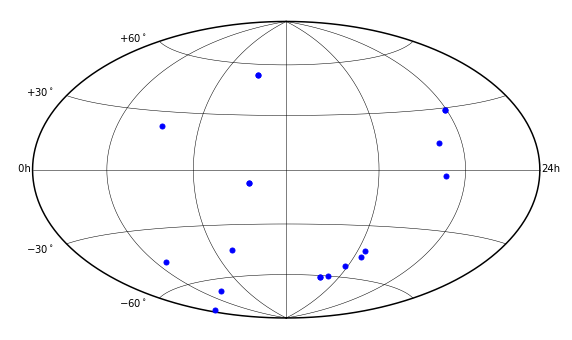

In [13]:
sou_dist_plot(edr3_timing200["ra_g"], edr3_timing200["dec_g"])

In [14]:
pos_err_tab[0, :] = calc_med_pos_err(edr3_timing200)

That is, we have 14 pulsars in the sample from DE200 vs. Gaia comparison.

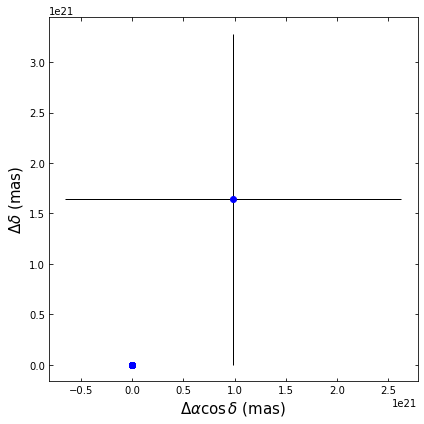

In [15]:
simple_plot(edr3_timing200)

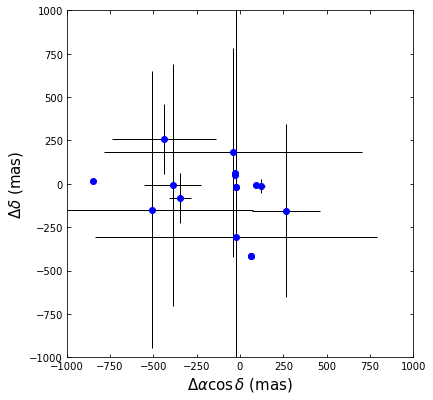

In [16]:
val_max = 1000
simple_plot(edr3_timing200, axis_lim=[-val_max, val_max, -val_max, val_max])

In [17]:
pmt200, sig200, indx, apr_chi2_200, pst_chi2_200 = rot_fit_4_table(
    edr3_timing200)

Iter.  NO.PSR  Apr.Chi2  Pos.Chi2  R1  R2  R3  rmPSR  rmPSREpoch  rmPSRChi2
Unit: mas
 1 15   3876.9   3704.4     112.74    -178.17     -53.74 J0857-4424    49080 113742.9
 2 14    392.5    328.8      53.95    -113.20      17.76 J0437-4715    49615   4239.0
 3 13    259.3    203.2      60.89     -92.49      46.42 J1435-6100    51270   1817.9
 4 13    153.6    139.1      22.62     -41.31      39.06 J1435-6100    51270   2660.1
 5 12     31.5     20.4     -36.91      36.69      28.51 J1955+2908    49718    156.3
 6 12     10.2      7.7      -9.30       1.23     -26.07 J1024-0719    50456     55.5
 7 12      7.9      5.3     -16.37      -8.96     -22.27 J1012+5307    50700      0.9
 8 12      7.1      5.7     -14.76      -4.66     -22.43 J1851+1259    49908     26.3
 9 11      6.3      4.8     -17.73      -2.89     -17.97 J1012+5307    50914      2.9
10 10      5.3      3.3    -123.72     132.38     -44.80 J1024-0719    51018      1.0
11  9      4.1      2.7      33.63     -64.19     166.

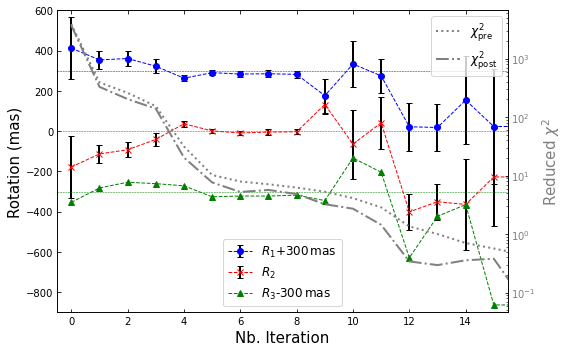

In [18]:
rot_vs_iter(pmt200,
            sig200, [-0.5, 15.5, -900, 600],
            #             add_text=[5, 150, "DE200 $-$ $Gaia$"],
            apr_chi2=apr_chi2_200,
            pst_chi2=pst_chi2_200,
            ax_loc="lower center",
            ax1_loc="upper right",
            y_shift=300)

I used the median values of the parameter estimations as the final estimate of rotation parameters.

The uncertainties of these estimates are given by interquatile range scaled by a factor of 1/1.35.

In [19]:
rot200, iqr200 = find_pmt_est(pmt200)

Calculate the postfit residuals.

In [20]:
dra_200, ddec_200 = calc_dpos(edr3_timing200, rot200)

Calculate the reduced $\chi^2$ before and after the LSQ adjustements.

In [21]:
a_chi2_200, p_chi2_200 = calc_chi2_4_fit(edr3_timing200, dra_200, ddec_200)

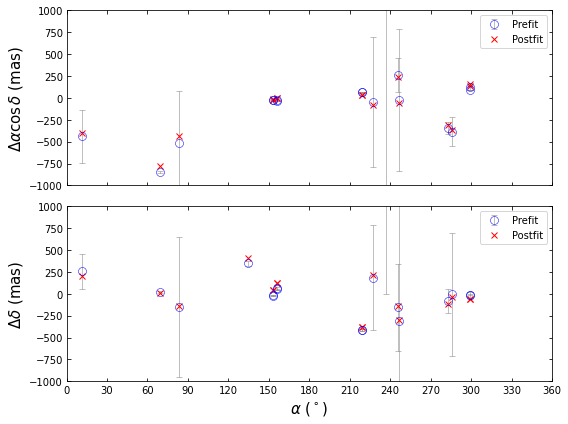

In [22]:
val_max = 1000
pos_oft_vs_coord(edr3_timing200, [-val_max, val_max],
                 dra_200,
                 ddec_200,
                 ref="g",
                 xaxis="ra")

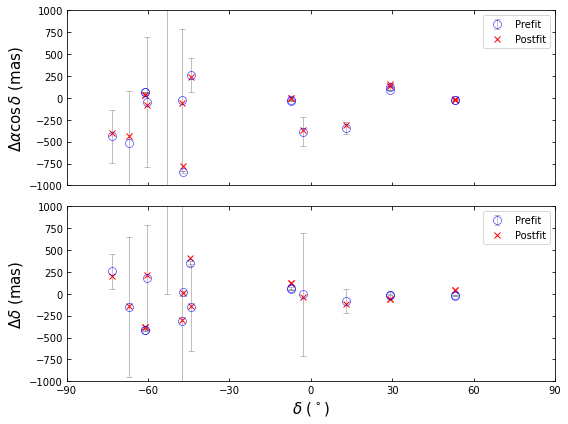

In [23]:
val_max = 1000
pos_oft_vs_coord(edr3_timing200, [-val_max, val_max],
                 dra_200,
                 ddec_200,
                 ref="g",
                 xaxis="dec",
                 #                  add_text=[-20, 700, "DE200 $-$ $Gaia$"]
                 )

A short table to summarize the orientation between DE frame and Gaia frame.

In [24]:
mydata = [[nb_psr_200, nb_obs_200,
           rot200[0], iqr200[0], rot200[1], iqr200[1], rot200[2], iqr200[2],
          a_chi2_200, p_chi2_200]]

myheaders = ["Nb.PSR", "Nb.Obs", "R1", "R1_err", "R2", "R2_err", "R3", "R3_err",
             "ApreFitChi2", "PostFitChi2"]
mystubs = ["DE200"]

tbl = SimpleTable(
    mydata,
    myheaders,
    mystubs,
    title="Orientation of DE frame wrt. Gaia frame (mas)",
    data_fmts=["%d", "%d", "%6.1f", "%6.1f", "%6.1f", "%6.1f", "%6.1f", "%6.1f",
               "%6.2f", "%6.2f"])

print(tbl)

                    Orientation of DE frame wrt. Gaia frame (mas)                    
      Nb.PSR Nb.Obs   R1   R1_err   R2   R2_err   R3   R3_err ApreFitChi2 PostFitChi2
-------------------------------------------------------------------------------------
DE200     15     19  -17.7  124.9  -64.2  166.4  -22.4   69.2     3562.52     3504.13
-------------------------------------------------------------------------------------


In [25]:
myheaders = ["RA_err_t", "dec_err_t", "pos_err_t",
             "RA_err_g", "dec_err_g", "pos_err_t"]
mystubs = ["DE200"]

tbl = SimpleTable(
    pos_err_tab,
    myheaders,
    mystubs,
    title="Positional formal uncertainty for timing and Gaia positions (mas)",
    data_fmts=["%6.2f", "%6.2f", "%6.2f", "%6.2f", "%6.2f", "%6.2f"])

print(tbl)

Positional formal uncertainty for timing and Gaia positions (mas)
      RA_err_t dec_err_t pos_err_t RA_err_g dec_err_g pos_err_t
---------------------------------------------------------------
DE200    26.20     40.00     47.82     0.21      0.21      0.29
---------------------------------------------------------------
